# The Quadratic Assignment Problem

In [295]:
##This is an initialization cell. Run this first
import pandas as pd
import numpy as np
from itertools import product
import time
import math
import matplotlib
import matplotlib.pyplot as plt

## Here we are creating a repository of different data sizes
We have our data from https://neos-guide.org/content/quadratic-assignment-problem and 
http://anjos.mgi.polymtl.ca/qaplib/
QAPLIB - A Quadratic Assignment Problem Library
R.E. BURKARD, E. ÇELA, S.E. KARISCH and F. RENDL

In [296]:
def CSVtoNumpyArray(rawdata):
    """
    Input: 
    rawdata = a csv file (insert name as a string)

    Output:
    two numpy matrices in a tuple
    """
    data = pd.read_csv(rawdata)  #Reads the data in as a pandas object
    c = data.columns
    column = int(c[0])
    final_data1 = data.iloc[:column,:].values  #Sets data into a series of numpy arrays of strings
    final_data2 = data.iloc[column:,:].values  #1 is for the first matrix(loc) and 2 is for the second(flow)
    

    #Forms the matrix as a numpy array (easier to work with) instead of an list of lists of strings
    def string_to_integers(final_data):
        matrix = []
        for j in range(column):
            string = final_data[j][0]
            string2 = string.split(" ")
            emptyarray = []
            for i in string2:
                if i != '':
                    emptyarray.append(int(i))
            matrix.append(emptyarray)
        npmatrix = np.array(matrix) 
        return npmatrix
    return string_to_integers(final_data1),string_to_integers(final_data2)

In [297]:
#REPOSITORY

#small sized matrices(under 10x10)
matrix_size_4 = 'tai4a.csv'
matrix_size_5 = 'tai5a.csv'
matrix_size_6 = 'tai6a.csv'
matrix_size_7 = 'tai7a.csv'
matrix_size_8 = 'tai8a.csv'
matrix_size_9 = 'tai9a.csv'

#medium sized matrices(ranging from 10x10 to 30x30)
matrix_size_10 = 'tai10a.csv'
matrix_size_11 = 'tai11a.csv'
matrix_size_12 = 'tai12a.csv'
matrix_size_15 = 'chr15a.csv' 
matrix_size_20 = 'chr20a.csv'
matrix_size_26 = 'bur26a.csv'

#large sized matrices(30x30 and bigger)
matrix_size_40 = 'tai40a.csv'
matrix_size_60 = 'tai60.csv'
matrix_size_80 = 'tai80.csv'
matrix_size_256 = 'tai256c.csv'

datamatrix = CSVtoNumpyArray(matrix_size_6) # Decide the size of problem to run in the code (clue: 
                                                #the number in the original name is the size)
MatrixLoc = datamatrix[0]
MatrixFlow = datamatrix[1]

## Preliminary functions

In [298]:
def ourpermutations(iterable, r=None):
    """
    Input:
    String or numbers separated by a space
    optional= the length that the permutations must be
    
    Output:
    a generator of permutations
    """
    
    pool = iterable.split(" ")
    n = len(pool)
    r = n if r is None else r
    for indices in product(range(n), repeat=r):
        if len(set(indices)) == r:
            yield list(pool[i] for i in indices)

In [299]:
#Demonstration of the Permutation function
"""
This is a very heavy generator - there seems to be litle to no way to make it more efficient. Even without 
printing every part of it is slow
"""
start = time.time()
r = ourpermutations('1 2 3' )# 8 9 10')
print(list(r))
#print(next(r))
#print(next(r))
#these are the time calculation
end = time.time()
thetime = end - start
print(thetime)

[['1', '2', '3'], ['1', '3', '2'], ['2', '1', '3'], ['2', '3', '1'], ['3', '1', '2'], ['3', '2', '1']]
0.0002453327178955078


In [300]:
def ExhaustiveSearchinputs(datamatrix):
    """
    Input:
    datamatrix: numpy array
    
    Output:
    list of every permutation allowed and the time it took to run(this is to help with the optimisation and 
    testing process)
    
    """
    
    # Important starting values
    start = time.time()
    length = len(datamatrix)
    thestring = ""
    
    #Generate the permutations
    for i in range(0,length):  #this is making a string of numbers from 0 to the size of the matrix -1
        thestring += str(i) + " "
    thestring = thestring[:-1]
    listofassociations = list(ourpermutations(thestring,length))  #this was the function we made earlier
    
    #these are the time calculation
    end = time.time()
    thetime = end - start
    return listofassociations, thetime,thestring
##########PLEASE NOTE THIS FUNCTION TAKES 4 seconds once datamatrix is length 8 and takes 99 seconds for 
##########length 9 so don't use values in the repository(use datamatrix size 3 for now)##############

### Time test for ExhaustiveSearchinputs

In [301]:
listofpermutations = ExhaustiveSearchinputs(MatrixLoc)[0]

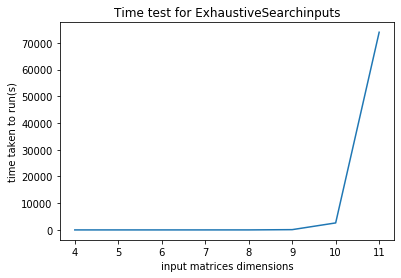

In [302]:
#plot
time_taken = [0.0004305839538574219, 0.0023462772369384766, 0.015115022659301758, 0.19432568550109863, 
              4.150153875350952, 101.804532289505, 2618.7232191562653,73961.41815924644]
length = [4,5,6,7,8,9,10,11]


fig, ax = plt.subplots()
ax.plot(length, time_taken)

ax.set(xlabel='input matrices dimensions', ylabel='time taken to run(s)',
       title='Time test for ExhaustiveSearchinputs')

fig.savefig("Time test for ExhaustiveSearchinputs.png")
plt.show()

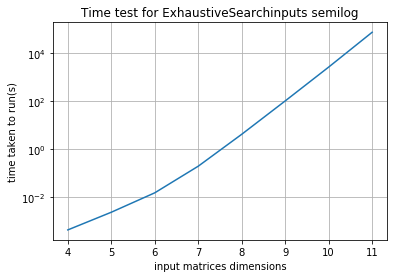

In [303]:
#semilogplot
time_taken = [0.0004305839538574219, 0.0023462772369384766, 0.015115022659301758, 0.19432568550109863, 
              4.150153875350952, 101.804532289505, 2618.7232191562653,73961.41815924644]
length = [4,5,6,7,8,9,10,11]

plt.grid(True, which="both")# Display grid

plt.semilogy(length, time_taken)
plt.xlabel('input matrices dimensions')# Give x axis label for the semilog plot
plt.ylabel('time taken to run(s)')# Give y axis label for the semilog plot

plt.title('Time test for ExhaustiveSearchinputs semilog')# Provide the title for the semilog plot
plt.savefig("Time test for ExhaustiveSearchinputs semilog.png")

plt.show()

# Exhaustive search

In [304]:
def generate_optimal_permutation(listofpermutations,MatrixLoc,MatrixFlow):
    """
    Input:
    MatrixLoc
    MatrixFlow
    listofpermutaions
    
    Output:
    The optimal permutation
    the optimal cost
    in a tuple
    """
    start = time.time()
    matrix_length = len(MatrixLoc)
    no_of_permutations = len(listofpermutations)
    arraysol = []
    
    #generate the multiples (that function we are optimising)
    for j in range(no_of_permutations):
        perm = listofpermutations[j]
        total = 0
        for i in range(matrix_length):
            for k in range(matrix_length):
                if i !=k:
                    total += MatrixLoc[i][k]*MatrixFlow[int(perm[i])][int(perm[k])]#this is that function that 
                                                #adds the products of different combinations of factories
        arraysol.append(total)
    
    finalcost = min(arraysol)
    finalindex = np.argmin(arraysol) #finds the optimal set of locations to factories(Which I stupidly 
                                        #called flow)
    end = time.time()
    thetime = end - start    
    return listofpermutations[finalindex],finalcost,thetime

In [305]:
#generate_optimal_permutation(listofpermutations,MatrixLoc,MatrixFlow)

In [306]:
solutionex = generate_optimal_permutation(listofpermutations,MatrixLoc,MatrixFlow)
print(solutionex)

(['4', '1', '5', '0', '3', '2'], 626, 0.046910762786865234)


# Branch and bound

In [307]:
def generate_optimal_permutationBnB(listofpermutations,MatrixLoc,MatrixFlow):
    """
    Input:
    MatrixLoc
    MatrixFlow
    listofpermutaions
    
    Output:
    The optimal permutation
    the optimal cost
    in a tuple
    """
    start = time.time()
    matrix_length = len(MatrixLoc)
    no_of_permutations = len(listofpermutations)
    arraysol = []
    bettersol = math.inf
    bettersolind = 0
    
    #generate the multiples (that function we are optimising)
    for k in range(no_of_permutations):
        perm = listofpermutations[k]
        total = 0
        i =0
        while i < matrix_length and bettersol>=total:
            j=0
            while j<matrix_length:
                if i!=j:
                    total += MatrixLoc[i][j]*MatrixFlow[int(perm[i])][int(perm[j])]
                j += 1
            i += 1
        if bettersol>total:
            bettersol = total
            bettersolind = k
        
    
    finalcost = bettersol
    finalindex = bettersolind
    end = time.time()
    thetime = end - start
    
    return listofpermutations[finalindex],finalcost,thetime

In [308]:
#generate_optimal_permutationBnB(listofpermutations,MatrixLoc,MatrixFlow)

In [309]:
solutionBnB = generate_optimal_permutationBnB(listofpermutations,MatrixLoc,MatrixFlow)
print(solutionBnB)

(['4', '1', '5', '0', '3', '2'], 626, 0.0192258358001709)


## Solutions

In [310]:
#storing permutation matrices
def NumpyArraytoCSV(permutations, number):
    import csv
    csvData = permutations
    name = "perm" + str(number) + ".csv"
    
    with open(name, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(csvData)

    csvFile.close()
    return True

In [311]:
NumpyArraytoCSV(listofpermutations,77)

True

In [312]:
def data_collection(start,end):
    """
    Output:
    tuple of Exhaustive search and Branch and Bound data
    perm,optimal weight,time"""
    Exhaustivesolutions = []
    Branchsolutions = []
    for q in range(start,end):
        datamatrix = CSVtoNumpyArray('tai' + str(q) +'a.csv')
        MatrixLoc = datamatrix[0]
        MatrixFlow = datamatrix[1]
        listofpermutations= ExhaustiveSearchinputs(MatrixLoc)[0]
        r = NumpyArraytoCSV(listofpermutations, q)
        solutionex = generate_optimal_permutation(listofpermutations,MatrixLoc,MatrixFlow)
        Exhaustivesolutions.append(solutionex)
        solutionBnB = generate_optimal_permutationBnB(listofpermutations,MatrixLoc,MatrixFlow)
        Branchsolutions.append(solutionBnB)
    return Exhaustivesolutions, Branchsolutions,r

In [313]:
finaldata = data_collection(4,5)
finaldata

([(['2', '3', '0', '1'], 790, 0.0005998611450195312)],
 [(['2', '3', '0', '1'], 790, 0.0005772113800048828)],
 True)

In [314]:
#The solutions for 4 until 11
final = ([(['2', '3', '0', '1'], 790, 0.0009167194366455078),
  (['1', '3', '4', '2', '0'], 628, 0.00436854362487793),
  (['4', '1', '5', '0', '3', '2'], 626, 0.022596359252929688),
  (['4', '3', '5', '2', '1', '6', '0'], 1478, 0.19768333435058594),
  (['5', '4', '3', '6', '7', '0', '2', '1'], 1808, 2.0959057807922363),
  (['2', '5', '8', '7', '6', '3', '4', '1', '0'], 2282, 23.58026623725891),
  (['8', '0', '7', '5', '9', '4', '3', '2', '6', '1'],135028, 286.9703893661499),
  (['8', '0', '6', '4', '9', '10', '5', '2', '7', '1', '3'],   190016,   3786.5291616916656)],
 [(['2', '3', '0', '1'], 790, 0.0009942054748535156),
  (['1', '3', '4', '2', '0'], 628, 0.003525257110595703),
  (['4', '1', '5', '0', '3', '2'], 626, 0.019068479537963867),
  (['4', '3', '5', '2', '1', '6', '0'], 1478, 0.15809869766235352),
  (['5', '4', '3', '6', '7', '0', '2', '1'], 1808, 1.4732763767242432),
  (['2', '5', '8', '7', '6', '3', '4', '1', '0'], 2282, 15.840143918991089),
  (['8', '0', '7', '5', '9', '4', '3', '2', '6', '1'],135028,221.24261617660522),
  (['8', '0', '6', '4', '9', '10', '5', '2', '7', '1', '3'],   190016,  3029.7006783485413)])

In [315]:
def plot_generator(finaldata):
    #plot
    length = list(range(4,12))
    time_taken_Ex = []
    time_taken_BnB = []
    
    for i in range(7):
        #print(i)
        time_taken_Ex.append(finaldata[0][i][2])
        time_taken_BnB.append(finaldata[1][i][2])
    time_taken_Ex.append(3786.5291616916656)
    time_taken_BnB.append(3029.7006783485413)
    
    Localsolver_times = [1,1,1,1,2,1,3,5,8,52,30,176,1013]
    Localsolver_size = [4,5,6,7,8,9,10,11,12,15,16,17,18]
    
    fig, ax = plt.subplots()
    ax.plot(length, time_taken_Ex,label= "exhaustive(dfs)")
    ax.plot(length, time_taken_BnB, label= "branch and bound")
    ax.plot(Localsolver_size, Localsolver_times,label= "Localsolver")
    
    ax.set(xlabel='input matrices dimensions', ylabel='time taken to run(s)',
           title='Time test for Exhaustive, Branch and bound and Localsolver')
    ax.legend()
    fig.savefig("Time test for Exhaustive, Branch and bound and Localsolver.jpg")
    plt.show()
    return True

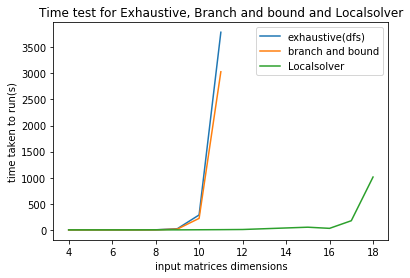

True

In [316]:
plot_generator(final)

In [317]:
def semilogplot_generator(finaldata):
    #plot
    length = list(range(4,12))
    time_taken_Ex = []
    time_taken_BnB = []
    
    for i in range(7):
        #print(i)
        time_taken_Ex.append(finaldata[0][i][2])
        time_taken_BnB.append(finaldata[1][i][2])

    time_taken_Ex.append(3786.5291616916656)
    time_taken_BnB.append(3029.7006783485413)
    
    plt.semilogy(length, time_taken_Ex,label= "exhaustive(dfs)")
    plt.semilogy(length,time_taken_BnB,label= "branch and bound")

    plt.xlabel('input matrices dimensions')# Give x axis label for the semilog plot
    plt.ylabel('time taken to run(s)')# Give y axis label for the semilog plot

    plt.title('Time test for Exhaustive and Branch and bound semilog')# Provide the title for the semilog plot
    plt.legend()
    plt.savefig("Time test for Exhaustive and Branch and bound semilog.png")

    plt.show()
    return True

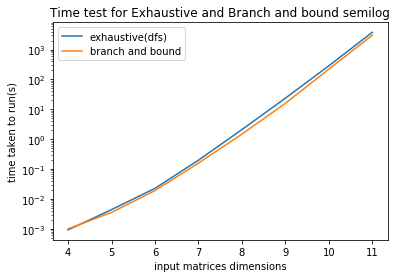

True

In [318]:
semilogplot_generator(final)

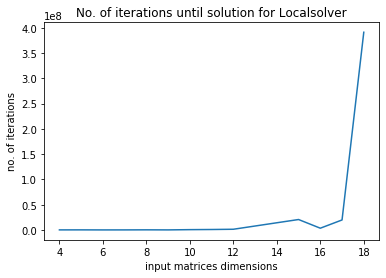

In [319]:
"""
So for the sizes 4, 5, 6 and 7 the value is found in less than one second and the program does not let me calculate times at less than 1 second.
Therefore all time values have an error of about -1 second. the iteration values are also an upper limit
"""
Localsolver_times = [1,1,1,1,2,1,3,5,8,52,30]
Localsolver_size = [4,5,6,7,8,9,10,11,12,15,16,17,18]
Localsolver_iterations = [317881,373066, 266261,298144,442266,308349,800151,1080000,1572150,20814250,3663640,19963086,391067290]

    
fig, ax = plt.subplots()
ax.plot(Localsolver_size, Localsolver_iterations)
    
ax.set(xlabel='input matrices dimensions', ylabel='no. of iterations',
       title='No. of iterations until solution for Localsolver')
fig.savefig("No. of iterations until solution for Localsolver.jpg")
plt.show()